In [1]:
import tensorflow as tf
print(tf.__version__)
!pip install -q tensorflow-datasets

2.3.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWHH1CG/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWHH1CG/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWHH1CG/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
import numpy as np
#get tf dataset with train and test
train_data, test_data = imdb['train'], imdb['test']
#create lists for both train and test
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

#convert tensors to numpy arrain and append to the created lists
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
#same for test data  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
#convert the labels lists to numpy arrays
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [4]:
#Hyperparameters
vocab_size = 10000
embedding_dim = 16 #dimensions for the embedding 
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) 
tokenizer.fit_on_texts(training_sentences) 
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)
#test, using the word_index from the training words ->> more OOV
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [5]:
#since the dictionary has the number at the end, we have to reverse the index
#to use the number index to check the values of it 

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

#check before and after the transformations applied to a sentence
print(decode_review(padded[3]))
print(training_sentences[3])
#-Removed Punctuation
#-OOV added
#-Padded at beggining(sentence shorter than 120)

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


In [6]:
#Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
#note that the embedding layer returns 1920 values when the input is 120,16


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [7]:
#train on 10 epochs
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 6s 8ms/step - loss: 0.4993 - accuracy: 0.7360 - val_loss: 0.3523 - val_accuracy: 0.8452
Epoch 2/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2432 - accuracy: 0.9048 - val_loss: 0.3858 - val_accuracy: 0.8322
Epoch 3/10
782/782 [==============================] - 6s 8ms/step - loss: 0.1005 - accuracy: 0.9735 - val_loss: 0.4530 - val_accuracy: 0.8237
Epoch 4/10
782/782 [==============================] - 7s 8ms/step - loss: 0.0254 - accuracy: 0.9970 - val_loss: 0.5329 - val_accuracy: 0.8256
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0063 - accuracy: 0.9996 - val_loss: 0.5987 - val_accuracy: 0.8267
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.6496 - val_accuracy: 0.8271
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 9.2250e-04 - accuracy: 1.0000 - val_loss: 0.6959 - val_accuracy: 0.8272
Ep

So now let's take a look at what we'll do to view this in the embedding projector. So first of all, I'm going to take the output of my embedding, which was modeled out layer zero, and we can see that there were 10,000 possible words and I had 16 dimensions. Here is where I'm going to iterate through that array to pull out the 16 dimensions, the values for the 16 dimensions per word and write that as out_V, which is my vectors.tsv. 

In [8]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim) 10000 words in 16 dimensions

(10000, 16)


In [9]:
weights[1] # values for one word in the 16 dimensions :D

array([ 0.01853774,  0.00533249,  0.00280966, -0.06989257,  0.08126964,
        0.05137248, -0.01643301, -0.05624749,  0.04638646, -0.00976376,
        0.04931377,  0.04067423,  0.06379446,  0.0447559 ,  0.04546497,
       -0.06691226], dtype=float32)

In [10]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size): #0 is OOV
  #use the number from the loop to get a word from the reversed index
  word = reverse_word_index[word_num] 
  embeddings = weights[word_num] #get the dimension values
  out_m.write(word + "\n") #the word and dimension values in dif files
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [11]:
#finally download the generated files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Then the files are upload and used in the embedding projector. https://projector.tensorflow.org/. In the following image, it can be seen how the word boring is on one side of the 3d representation, and related words with similar values on their vectors represented in the 3d space. 


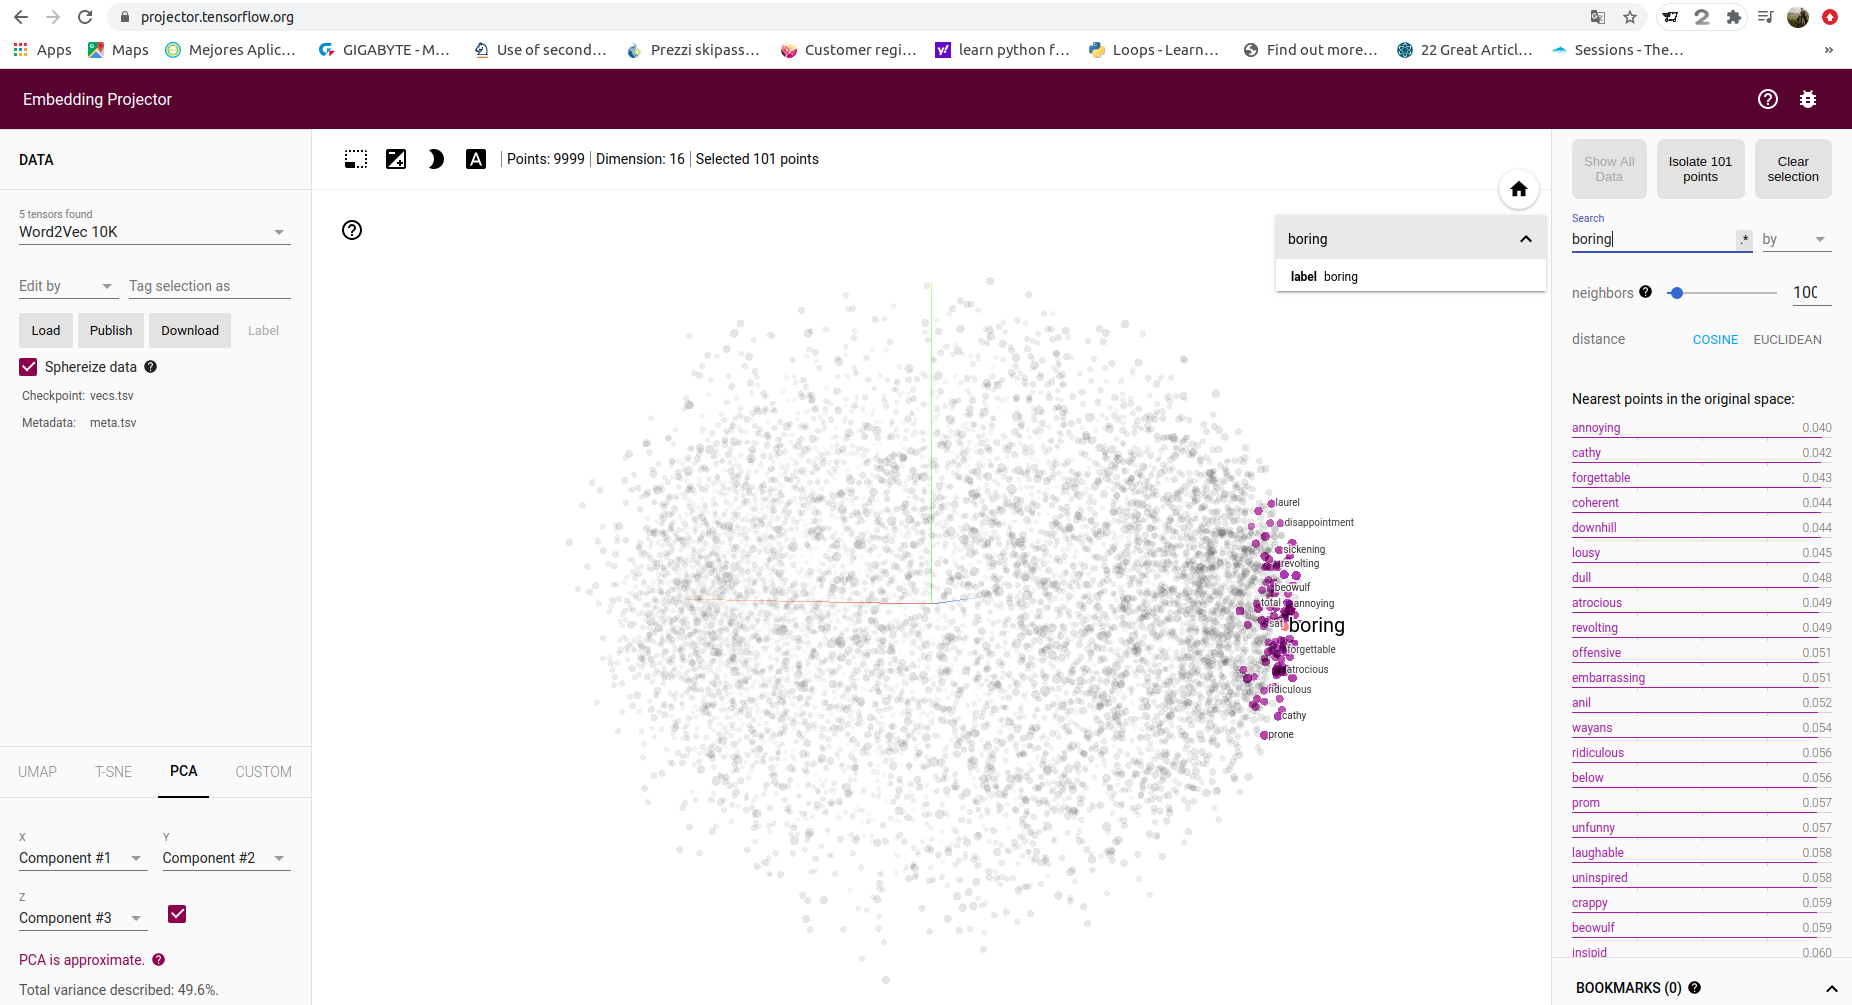